In [71]:
library(tidyverse)
library(plotly)
library(maps)
library(rbokeh)
library(widgetframe)
library(htmlwidgets)

# For text analysis
library(tm)
library(SnowballC)
library(wordcloud)

In [23]:
df <- read_csv("Tweets.csv")

Parsed with column specification:
cols(
  tweet_id = col_double(),
  airline_sentiment = col_character(),
  airline_sentiment_confidence = col_double(),
  negativereason = col_character(),
  negativereason_confidence = col_double(),
  airline = col_character(),
  airline_sentiment_gold = col_character(),
  name = col_character(),
  negativereason_gold = col_character(),
  retweet_count = col_integer(),
  text = col_character(),
  tweet_coord = col_character(),
  tweet_created = col_character(),
  tweet_location = col_character(),
  user_timezone = col_character()
)


In [24]:
head(df)

tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5.703061e+17,neutral,1.0000,NA,NA,Virgin America,NA,cairdin,NA,0,@VirginAmerica What @dhepburn said.,NA,2015-02-24 11:35:52 -0800,NA,Eastern Time (US & Canada)
5.703011e+17,positive,0.3486,NA,0.0000,Virgin America,NA,jnardino,NA,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NA,2015-02-24 11:15:59 -0800,NA,Pacific Time (US & Canada)
5.703011e+17,neutral,0.6837,NA,NA,Virgin America,NA,yvonnalynn,NA,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NA,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NA,jnardino,NA,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NA,2015-02-24 11:15:36 -0800,NA,Pacific Time (US & Canada)
5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NA,jnardino,NA,0,@VirginAmerica and it's a really big bad thing about it,NA,2015-02-24 11:14:45 -0800,NA,Pacific Time (US & Canada)
5.703008e+17,negative,1.0000,Can't Tell,0.6842,Virgin America,NA,jnardino,NA,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA,NA,2015-02-24 11:14:33 -0800,NA,Pacific Time (US & Canada)


In [25]:
# Remove the @airline tag in the tweets

df$text = gsub("^@\\w+ *", "", df$text)
head(df)

tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5.703061e+17,neutral,1.0000,NA,NA,Virgin America,NA,cairdin,NA,0,What @dhepburn said.,NA,2015-02-24 11:35:52 -0800,NA,Eastern Time (US & Canada)
5.703011e+17,positive,0.3486,NA,0.0000,Virgin America,NA,jnardino,NA,0,plus you've added commercials to the experience... tacky.,NA,2015-02-24 11:15:59 -0800,NA,Pacific Time (US & Canada)
5.703011e+17,neutral,0.6837,NA,NA,Virgin America,NA,yvonnalynn,NA,0,I didn't today... Must mean I need to take another trip!,NA,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NA,jnardino,NA,0,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NA,2015-02-24 11:15:36 -0800,NA,Pacific Time (US & Canada)
5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NA,jnardino,NA,0,and it's a really big bad thing about it,NA,2015-02-24 11:14:45 -0800,NA,Pacific Time (US & Canada)
5.703008e+17,negative,1.0000,Can't Tell,0.6842,Virgin America,NA,jnardino,NA,0,seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA,NA,2015-02-24 11:14:33 -0800,NA,Pacific Time (US & Canada)


In [26]:
# Dividing data into 2 - one for positive sentiment and the other for negative
positive_tweets = subset(df, airline_sentiment == "positive")
negative_tweets = subset(df, airline_sentiment == "negative")
dim(positive_tweets); dim(negative_tweets)

[1] 2363   15

[1] 9178   15

In [47]:
wordsToRemove = c('get', 'cant', 'can', 'now', 'just', 'will', 'dont', 'ive', 'got', 'much')

# generate a function to analyse corpus text
analyseText = function(text_to_analyse){
    # analyse text and generate matrix of words
    # Returns a dataframe containing 1 tweet per row, one word per column
    # and the number of times the word appears per tweet
    CorpusTranscript = VCorpus(VectorSource(text_to_analyse))
    CorpusTranscript = tm_map(CorpusTranscript, content_transformer(tolower), lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, PlainTextDocument, lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, removePunctuation)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, wordsToRemove)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, stopwords("english"))
    CorpusTranscript = DocumentTermMatrix(CorpusTranscript)
    CorpusTranscript = removeSparseTerms(CorpusTranscript, 0.97) # keeps a matrix 97% sparse
    CorpusTranscript = as.data.frame(as.matrix(CorpusTranscript))
    colnames(CorpusTranscript) = make.names(colnames(CorpusTranscript))
    
    return(CorpusTranscript)
}

In [28]:
words_in_negative_sentiment = analyseText(negative_tweets$text)
dim(words_in_negative_sentiment)

[1] 9178   30

In [42]:
frequency_of_words_neg = colSums(words_in_negative_sentiment)
frequency_of_words_neg = frequency_of_words_neg[order(frequency_of_words_neg, decreasing = T)]
head(frequency_of_words_neg)

flight cancelled   service     hours      help      hold 
     2900       920       740       644       610       607

In [30]:
words_in_positive_sentiment = analyseText(positive_tweets$text)
dim(words_in_positive_sentiment)

[1] 2363   18

In [43]:
frequency_of_words_pos = colSums(words_in_positive_sentiment)
frequency_of_words_pos = frequency_of_words_pos[order(frequency_of_words_pos, decreasing = T)]
head(frequency_of_words_pos)

thanks   thank  flight   great service    love 
    608     453     371     233     159     133

In [44]:
frequency_of_words_pos[1] = frequency_of_words_pos[1] + frequency_of_words_pos[2]
frequency_of_words_pos = frequency_of_words_pos[-2]
head(frequency_of_words_pos)

thanks   flight    great  service     love customer 
    1061      371      233      159      133      113

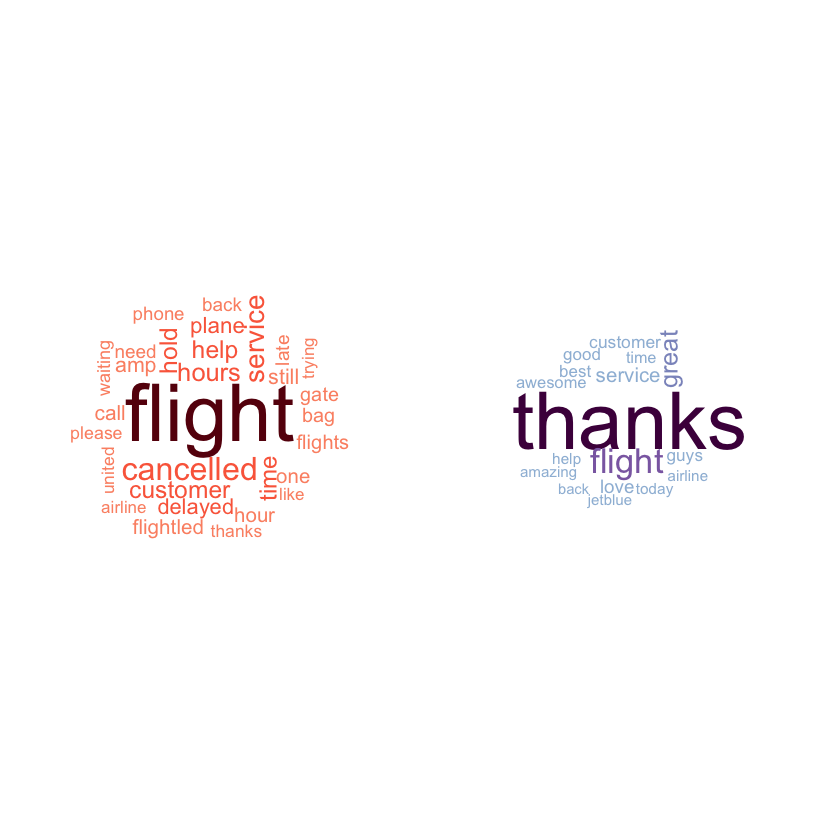

In [46]:
# word clouds
par(mfrow = c(1,2))

wordcloud(freq = as.vector(frequency_of_words_neg), words = names(frequency_of_words_neg), random.order = FALSE,
          random.color = FALSE, colors = brewer.pal(9, 'Reds')[4:9])

wordcloud(freq = as.vector(frequency_of_words_pos), words = names(frequency_of_words_pos),random.order = FALSE,
          random.color = FALSE, colors = brewer.pal(9, 'BuPu')[4:9])

In [48]:
# generate a function to analyse corpus text and return a document term matrix instead of dataframe
# we can perform further analysis on document term matrices
analyseText2 = function(text_to_analyse){
    # analyse text and generate matrix of words
    # Returns a dtm containing 1 tweet per row, one word per column
    # and the number of times the word appears per tweet
    CorpusTranscript = VCorpus(VectorSource(text_to_analyse))
    CorpusTranscript = tm_map(CorpusTranscript, content_transformer(tolower), lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, PlainTextDocument, lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, removePunctuation)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, wordsToRemove)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, stopwords("english"))
    CorpusTranscript = DocumentTermMatrix(CorpusTranscript)
    CorpusTranscript = removeSparseTerms(CorpusTranscript, 0.97) # keeps a matrix 97% sparse
    
    return(CorpusTranscript)
}

In [52]:
words_neg = analyseText2(negative_tweets$text)
findAssocs(words_neg, c("flight", 'customer', 'gate', 'phone'), .04)

$flight
cancelled      late flightled   delayed      hour     hours 
     0.36      0.25      0.23      0.16      0.05      0.05 

$customer
service 
   0.65 

$gate
waiting   plane 
   0.09    0.08 

$phone
help call hour 
0.07 0.06 0.04

In [51]:
words_pos = analyseText2(positive_tweets$text)
findAssocs(words_pos, c("flight", 'awesome', 'amazing', 'service'), .04)

$flight
great  time  back 
 0.13  0.06  0.04 

$awesome
guys 
0.07 

$amazing
customer     best     love 
    0.08     0.06     0.05 

$service
customer    great    today     best 
    0.67     0.16     0.08     0.06

Warning message in plot.window(...):
“"hang" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”Warning message in title(...):
“"hang" is not a graphical parameter”

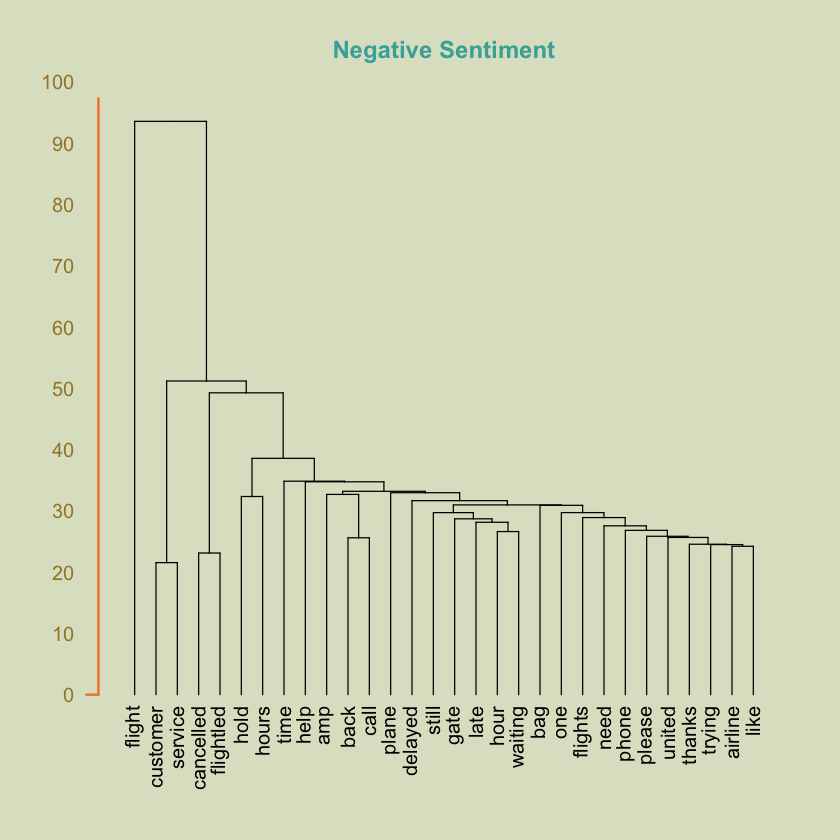

In [68]:
d = dist(t(as.matrix(words_neg)), method = "euclidean")
fit = hclust(d = d, method = 'ward.D')
hcd = as.dendrogram(fit)

op = par(bg = "#DDE3CA")
plot(hcd, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", main = 'Negative Sentiment', xlab = '',
     col.axis = "#F38630", lwd = 3, lty = 3, sub = NULL, hang = -1, axes = FALSE)
# add axis
axis(side = 2, at = seq(0, 400, 100), col = "#F38630", labels = FALSE, 
     lwd = 2)
# add text in margin
mtext(seq(0, 100, 10), side = 2, at = seq(0, 100, 10), line = 1, 
      col = "#A38630", las = 2)

Warning message in plot.window(...):
“"hang" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”Warning message in title(...):
“"hang" is not a graphical parameter”

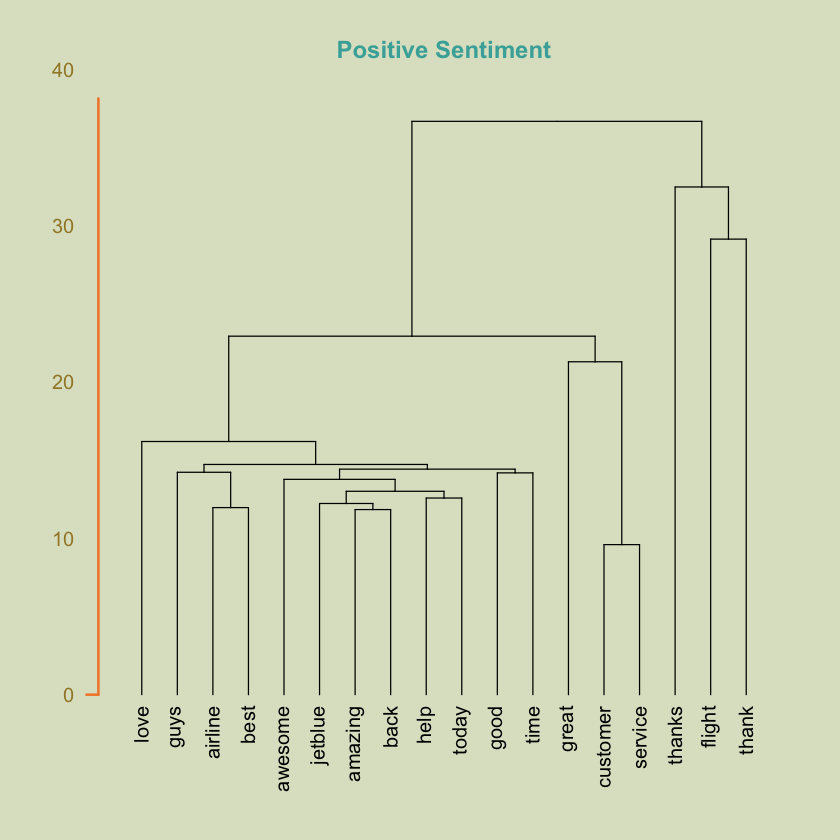

In [69]:
d = dist(t(as.matrix(words_pos)), method = "euclidean")
fit = hclust(d = d, method = 'ward.D')
hcd = as.dendrogram(fit)

op = par(bg = "#DDE3CA")
plot(hcd, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", main = 'Positive Sentiment', xlab = '',
     col.axis = "#F38630", lwd = 3, lty = 3, sub = NULL, hang = -1, axes = FALSE)
# add axis
axis(side = 2, at = seq(0, 400, 100), col = "#F38630", labels = FALSE, 
     lwd = 2)
# add text in margin
mtext(seq(0, 100, 10), side = 2, at = seq(0, 100, 10), line = 1, 
      col = "#A38630", las = 2)